# Initialization

In [1]:
import os
import sys
print(sys.executable)    # vérification
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable



/Users/gaelleba/anaconda3/envs/sparkEnv/bin/python


In [2]:

import pyspark
from pyspark.sql import SparkSession
import sparknlp
sparknlp.start()

#pip install --upgrade spark-nlp
print(sparknlp.version())

:: loading settings :: url = jar:file:/Users/gaelleba/anaconda3/envs/sparkEnv/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/gaelleba/.ivy2/cache
The jars for the packages stored in: /Users/gaelleba/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-fa3c006f-5982-4990-a8df-fc339293bdef;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.5.1 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.12.500 in 

5.5.1


In [3]:
!pwd

/Users/gaelleba/Library/CloudStorage/Dropbox/CNAM/RCP216/RCP216_PROJECT/2-AbstractsCollection/Abstract_analysis


In [4]:
import pandas as pd
path='/Users/gaelleba/Library/CloudStorage/Dropbox/CNAM/RCP216/RCP216_PROJECT/'
source_file=f'{path}unique_abstracts_dates.csv'
df_abstracts=pd.read_csv(source_file, sep='\t', header=0)


In [5]:

def extract_year(pubdate):
    year = pubdate.strip("[]").split(',')[0]
    return int(year.strip("'"))

df_abstracts['Year'] = df_abstracts['Pubdate'].apply(extract_year)
#df_abstracts.info()
abstracts = df_abstracts["Abstract"].tolist()
years = df_abstracts["Year"].astype(int).tolist()

In [6]:
from pyspark.sql.functions import lit
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.functions import udf
spark = SparkSession.builder.getOrCreate()

# Define the schema
schema = StructType([
    StructField("abstract", StringType(), True),
    StructField("year", IntegerType(), True)
])

# Create DataFrame
data = [(abstracts[i], years[i]) for i in range(len(df_abstracts))]
Sptext = spark.createDataFrame(data, schema=schema)
Sptext.show(10)

## Create Full data frame
full = spark.read.format("csv").option("header", True) \
.option("sep", "\t") \
.load(source_file)

full = full.join(Sptext, on="abstract").drop("Pubdate")
full.show(10)

+--------------------+----+
|            abstract|year|
+--------------------+----+
|It has been firml...|2014|
|Although the asso...|2006|
|This study examin...|2014|
|The electrophysio...|2014|
|Time-of-day effec...|2000|
|Epidemiological a...|2017|
|TMS combined with...|2007|
|The aim of the pr...|2003|
|The authors studi...|2010|
|Despite the subje...|2018|
+--------------------+----+
only showing top 10 rows



Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=27893Kb max_used=27893Kb free=103178Kb
 bounds [0x00000001071e8000, 0x0000000108d48000, 0x000000010f1e8000]
 total_blobs=10197 nmethods=9242 adapters=867
 compilation: disabled (not enough contiguous free space left)
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+---------------+--------+----+
|            Abstract|               Title|                 DOI|          MeSH_Terms|         Pubmed link|drug_name_list|pubchem_id_list|    PMID|year|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+---------------+--------+----+
|It has been firml...|Oscillatory spati...|DOI: 10.1016/j.al...|['Adult', 'Alcoho...|https://pubmed.nc...|   ['Ethanol']|          [702]|24530007|2014|
|Although the asso...|Effects of alcoho...|DOI: 10.1111/j.15...|['Adult', 'Breath...|https://pubmed.nc...|   ['Ethanol']|          [702]|16737455

# Pre-traitement: embedding

In [8]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
from sparknlp.pretrained import PretrainedPipeline

# Assemblage du document
documentAssembler = DocumentAssembler() \
                      .setCleanupMode("inplace") \
                      .setInputCol("Abstract") \
                      .setOutputCol("document")

# Tokenisation
tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')
    # suppression des caracteres spéciaux tout en gardant les expressions alphanumériques

# Normalisation
normalizer = Normalizer() \
        .setInputCols(["token"]) \
        .setOutputCol("normalized") \
        .setLowercase(True) \
        .setCleanupPatterns(["""[^a-zA-Z\s]"""]) # remove all non-alphabetic characters

# Lemmatisation
lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(['normalized']) \
    .setOutputCol('lemma')

# Suppression des mots vides
stopwords_cleaner = StopWordsCleaner.pretrained() \
    .setInputCols(['lemma']) \
    .setOutputCol('clean_lemma')
    
# Doc2Vec embeddings
embeddings = Doc2VecApproach() \
    .setInputCols(["clean_lemma"]) \
    .setOutputCol("embeddings")


finisher = EmbeddingsFinisher() \
                           .setInputCols("embeddings") \
                           .setOutputCols("output") \
                           .setOutputAsVector(True) \
                           .setCleanAnnotations(False)

# Pipeline
pipeline_embed = Pipeline(stages=[
    documentAssembler,
    tokenizer,
    normalizer,
    lemmatizer,
    stopwords_cleaner,
    embeddings,
    finisher
])
    
# Application du pipeline
model_embed = pipeline_embed.fit(full)
result_embed = model_embed.transform(full)
result_embed.printSchema()
result_embed.select("Title", "output").show(10, 300)

<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
/var/folders/ym/bgkz_f9x4f7dygsy5ydxzyb80000gn/T/ipykernel_78417/1030342832.py:24: SyntaxWarning: invalid escape sequence '\s'
  .setCleanupPatterns(["""[^a-zA-Z\s]"""]) # remove all non-alphabetic characters


lemma_antbnc download started this may take some time.


25/01/01 16:25:20 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


Approximate size to download 907.6 KB
[OK!]
stopwords_en download started this may take some time.


25/01/01 16:25:23 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


Approximate size to download 2.9 KB
[OK!]


root
 |-- Abstract: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- DOI: string (nullable = true)
 |-- MeSH_Terms: string (nullable = true)
 |-- Pubmed link: string (nullable = true)
 |-- drug_name_list: string (nullable = true)
 |-- pubchem_id_list: string (nullable = true)
 |-- PMID: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- token: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-

In [9]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType
import numpy as np
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col
from pyspark.ml.functions import array_to_vector


# Define a UDF to average the vectors
def average_vectors(vectors):
    avg_vector = np.mean(vectors, axis=0)
    return avg_vector.tolist()

average_vectors_udf = udf(average_vectors, ArrayType(FloatType()))
# Apply the UDF to create a new column with the averaged vectors
result_modif = result_embed.withColumn("mean_output", average_vectors_udf(result_embed["output"]))
result_modif.printSchema()

result_modif = result_modif.withColumn("features", array_to_vector("mean_output"))


result_modif.printSchema()
result_modif.select("Title", "mean_output", "features").show(10, 200)


root
 |-- Abstract: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- DOI: string (nullable = true)
 |-- MeSH_Terms: string (nullable = true)
 |-- Pubmed link: string (nullable = true)
 |-- drug_name_list: string (nullable = true)
 |-- pubchem_id_list: string (nullable = true)
 |-- PMID: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- token: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-

+-----------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                                          Title|                                                                                                                                                                                             mean_output|                                                                                                          

# PCA 

In [11]:
vector_size = result_modif.select("features").first()["features"].size
print(f"Size of the vectors in the features column: {vector_size}")

Size of the vectors in the features column: 100


In [13]:
from pyspark.ml.feature import PCA
# Décomposition en valeurs singulières (SVD), nombre k de composants retenus
MaxComp=3
pca = PCA(k=MaxComp, inputCol="features", outputCol="PCA_Features")

# Application du pipeline avec SVD
model_pca = pca.fit(result_modif)
result_pca = model_pca.transform(result_modif)
result_pca.select("Title", "PCA_Features").show(10, 100)


25/01/01 16:27:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+----------------------------------------------------------------------------------------------------+-----------------------------------------------------------------+
|                                                                                               Title|                                                     PCA_Features|
+----------------------------------------------------------------------------------------------------+-----------------------------------------------------------------+
|Oscillatory spatial profile of alcohol's effects on the resting state: anatomically-constrained MEG.|  [-0.06482781553934969,-0.3003153702488049,0.013693407148266093]|
|              Effects of alcohol on sleep and the sleep electroencephalogram in healthy young women.| [-0.2127796577180176,-0.047864673256557036,-0.25154973077521525]|
|Spatio-temporal processing of words and nonwords: hemispheric laterality and acute alcohol intoxi...| [0.04343274309486366,-0.0662445039564638,-0.00226459

## Plotting 

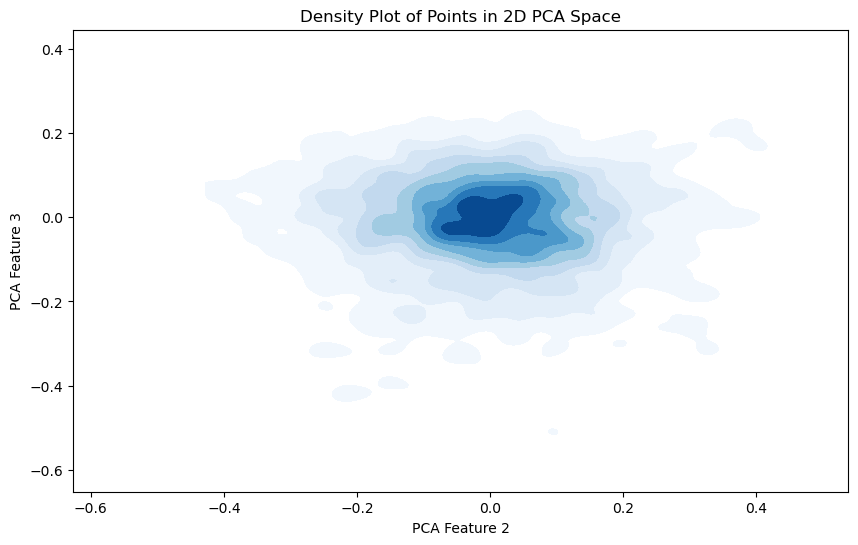

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extraction des caractéristiques PCA
pca_features = np.array(result_pca.select("PCA_Features").rdd.map(lambda row: row.PCA_Features).collect())

# Création du graphique de densité
plt.figure(figsize=(10, 6))
sns.kdeplot(x=pca_features[:, 1], y=pca_features[:, 2], cmap="Blues", fill=True, bw_adjust=0.5)
plt.title('Density Plot of Points in 2D PCA Space')
plt.xlabel('PCA Feature 2')
plt.ylabel('PCA Feature 3')
plt.show()


In [15]:
from pyspark.sql.functions import length

# Calculate the length of the abstract
result_pca = result_pca.withColumn("AbstractLength", length("Abstract"))
# Select necessary columns
data = result_pca.select("Title", "Year", "AbstractLength", "PCA_Features")
# Convert to Pandas DataFrame
pandas_df = data.toPandas()
# Extract PCA features into separate columns
pandas_df[['PCA1', 'PCA2', 'PCA3']] = pd.DataFrame(pandas_df['PCA_Features'].tolist(), index=pandas_df.index)[[0, 1, 2]]


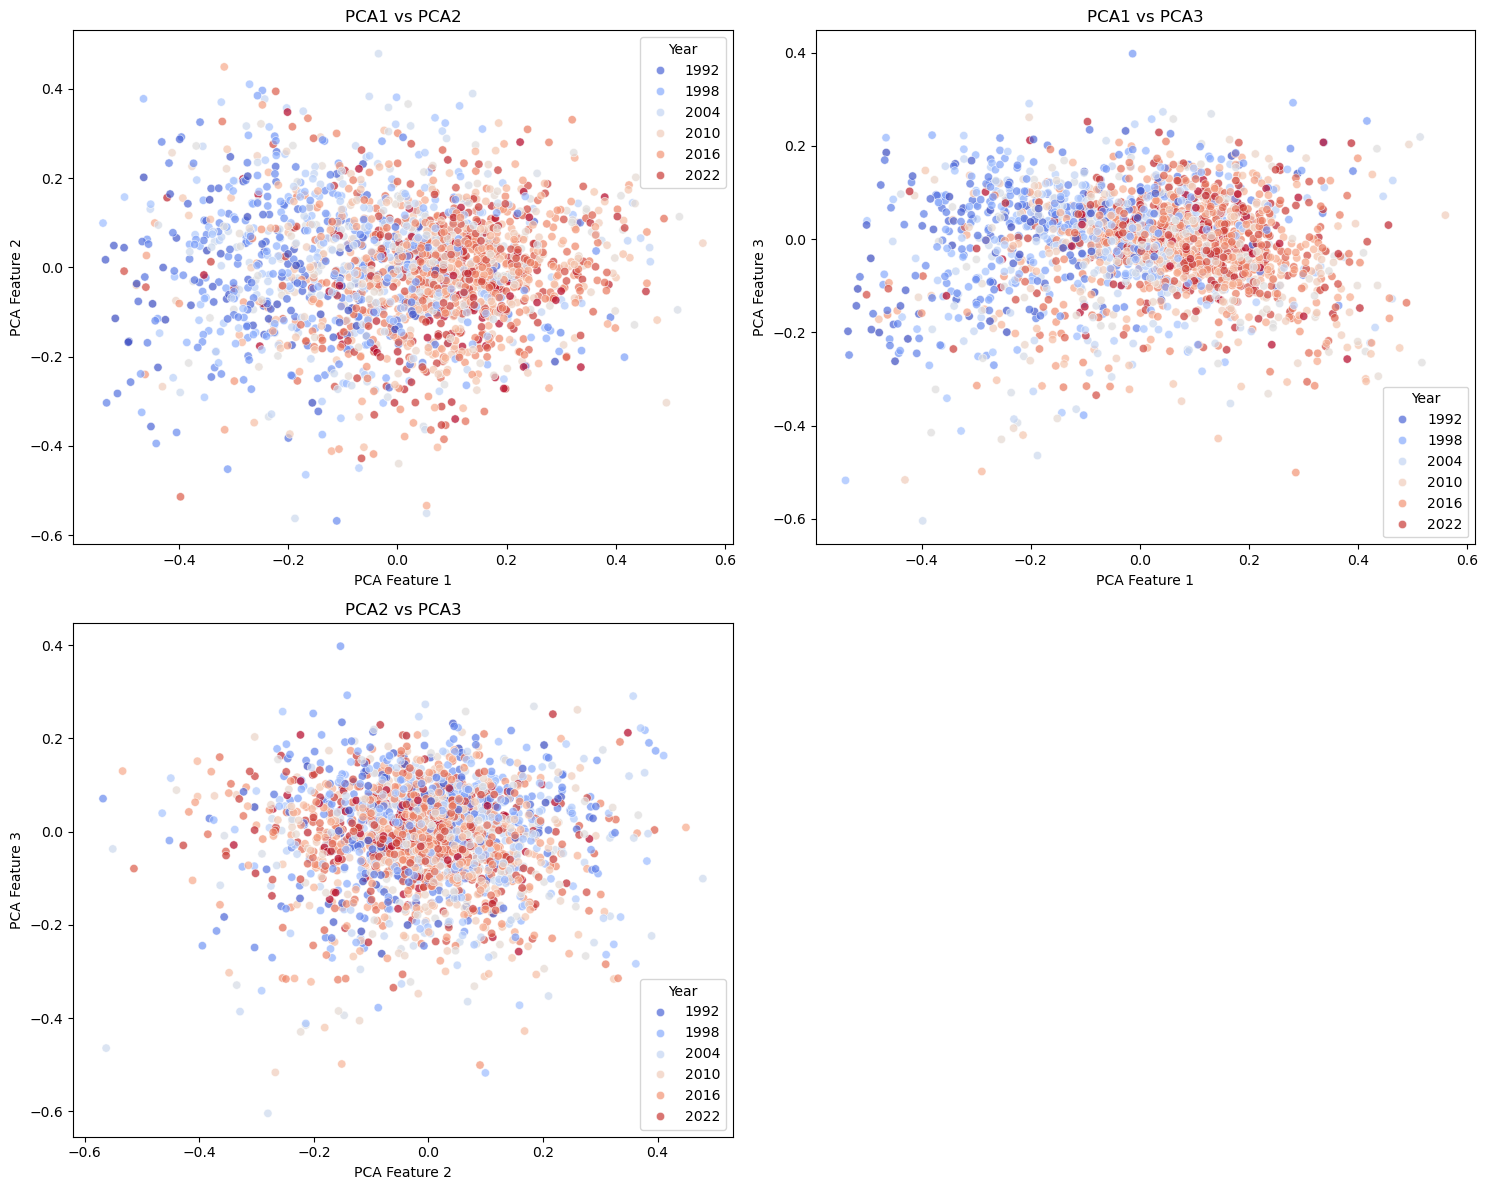

In [16]:
def pca_plot(df, color_feature, palette):
    
    # Plot all PCA combinations in a single figure with small panels
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # PCA Feature 1 vs PCA Feature 2
    sns.scatterplot(data=df, x='PCA1', y='PCA2', hue=color_feature, palette=palette, alpha=0.7, ax=axes[0, 0])
    axes[0, 0].set_title('PCA1 vs PCA2')
    axes[0, 0].set_xlabel('PCA Feature 1')
    axes[0, 0].set_ylabel('PCA Feature 2')

    # PCA Feature 1 vs PCA Feature 3
    sns.scatterplot(data=df, x='PCA1', y='PCA3', hue=color_feature, palette=palette, alpha=0.7, ax=axes[0, 1])
    axes[0, 1].set_title('PCA1 vs PCA3')
    axes[0, 1].set_xlabel('PCA Feature 1')
    axes[0, 1].set_ylabel('PCA Feature 3')

    # PCA Feature 2 vs PCA Feature 3
    sns.scatterplot(data=df, x='PCA2', y='PCA3', hue=color_feature, palette=palette, alpha=0.7, ax=axes[1, 0])
    axes[1, 0].set_title('PCA2 vs PCA3')
    axes[1, 0].set_xlabel('PCA Feature 2')
    axes[1, 0].set_ylabel('PCA Feature 3')

    # Hide the empty subplot
    axes[1, 1].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    
pca_plot(pandas_df, 'Year', 'coolwarm')

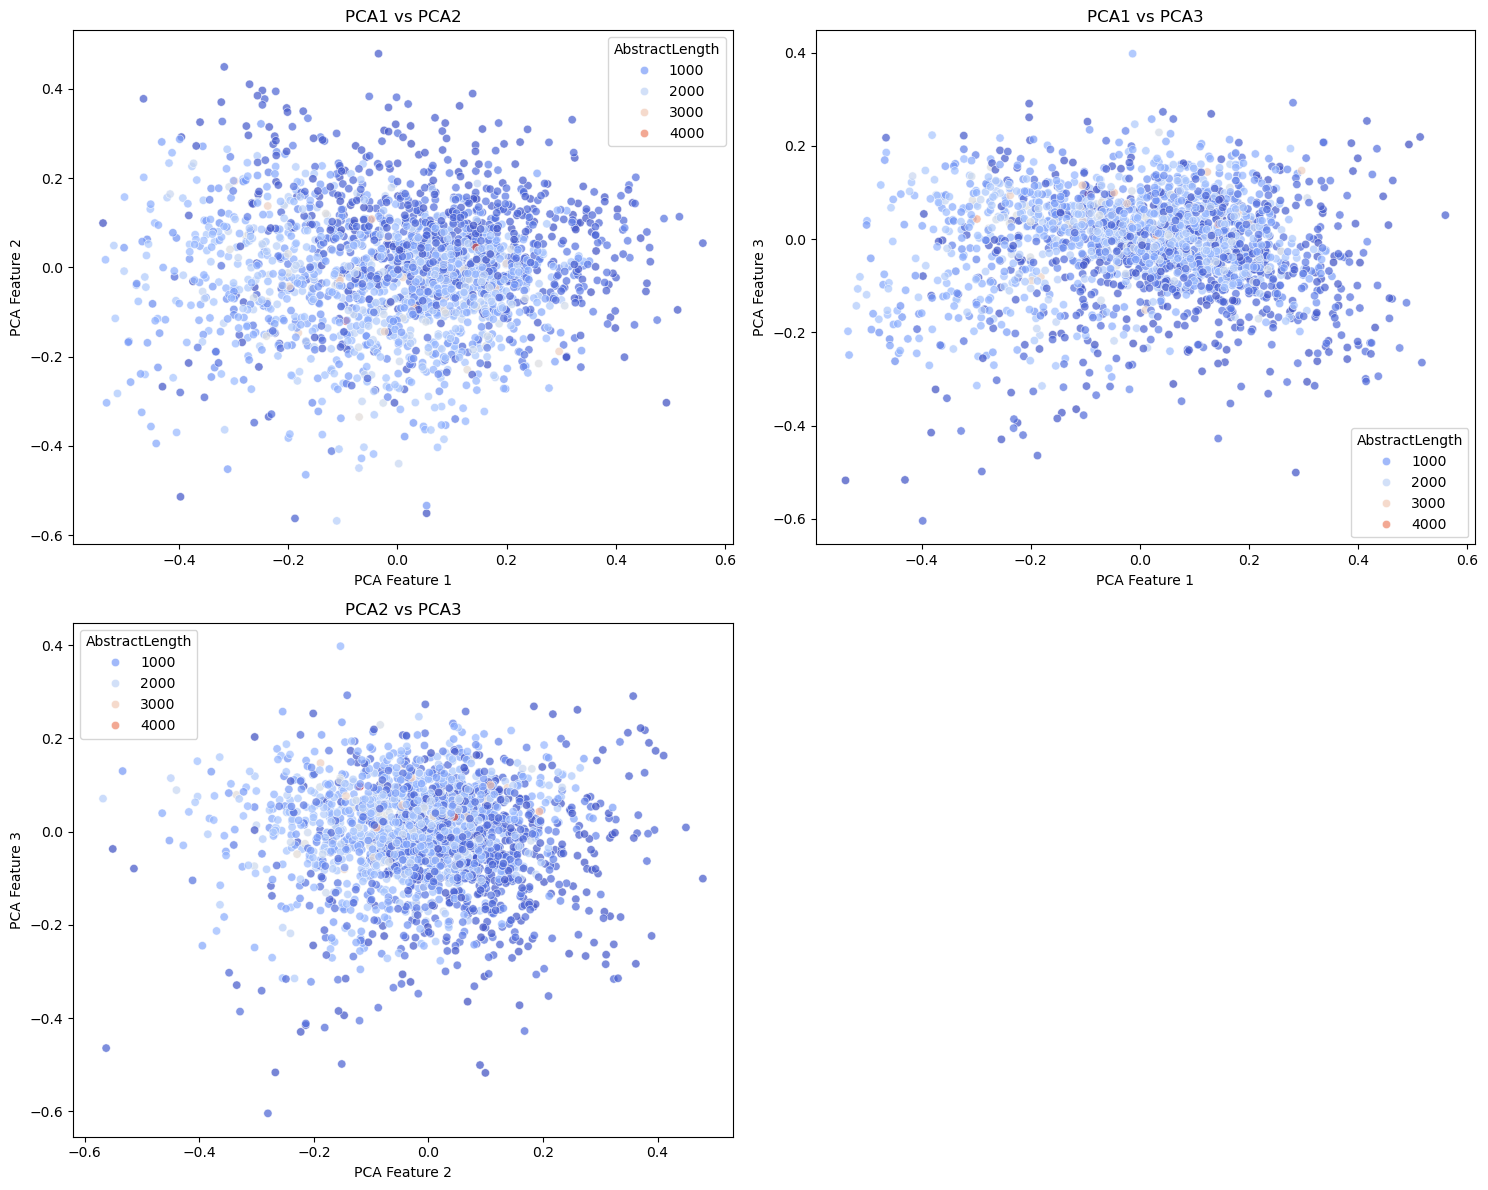

In [17]:
pca_plot(pandas_df, 'AbstractLength', 'coolwarm')

# K-means clustering

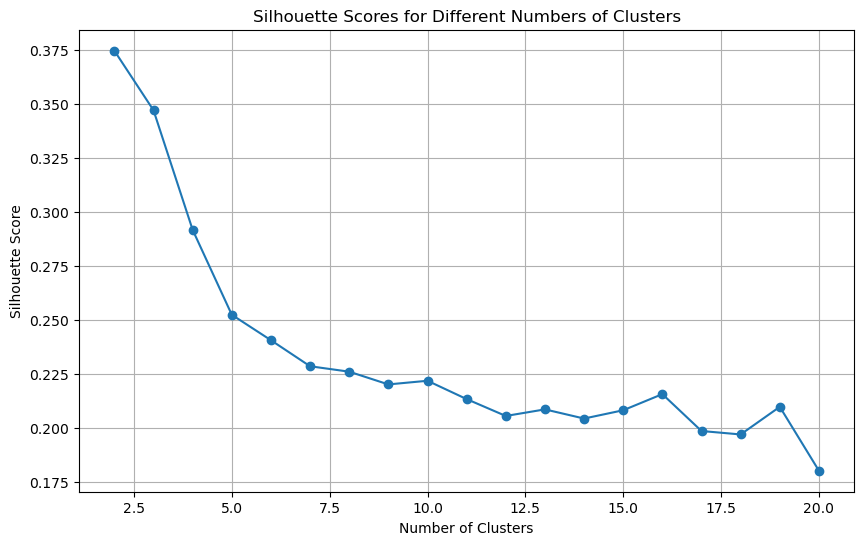

In [32]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

import matplotlib.pyplot as plt

# Initialize lists to store the number of clusters and corresponding silhouette scores
num_clusters = list(range(2, 21))
silhouette_scores = []


def test_kmeans(df, features):
    # Loop through the range of cluster numbers
    for k in num_clusters:
        # Apply k-means
        kmeans = KMeans().setK(k).setMaxIter(100).setSeed(100).setFeaturesCol(features).setPredictionCol("assigned_topic")
        model = kmeans.fit(df)
        
        # Transform the data
        kmeans_test = model.transform(df)
        
        # Evaluate the clustering by the silhouette score
        evaluator = ClusteringEvaluator().setFeaturesCol(features).setPredictionCol("assigned_topic")
        silhouette = evaluator.evaluate(kmeans_test)
        
        # Append the silhouette score to the list
        silhouette_scores.append(silhouette)

    # Plot the silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(num_clusters, silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Different Numbers of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()
    
test_kmeans(result_modif, 'features')

In [33]:
from pyspark.ml.clustering import KMeans

def kmeans(df, features, k):
    # Appliquer k-means
    kmeans = KMeans()\
        .setK(k)\
        .setMaxIter(200)\
        .setSeed(100)\
        .setFeaturesCol(features).setPredictionCol("assigned_topic")
        
    modele = kmeans.fit(df)

    # Trouver l'indice de groupe pour chaque donnée
    kmeans_res = modele.transform(df)
    kmeans_res.select('Title', 'assigned_topic').show(10)
    
    return kmeans_res
    
kmeans_res=kmeans(result_modif, 'features', 16)

+--------------------+--------------+
|               Title|assigned_topic|
+--------------------+--------------+
|Oscillatory spati...|             6|
|Effects of alcoho...|            12|
|Spatio-temporal p...|             3|
|Alcohol reduces c...|             0|
|Time-of-day effec...|            14|
|Impairment due to...|             8|
|Effects of alcoho...|             3|
|Convergent and di...|            11|
|When the brain ch...|             3|
|Effects of alcoho...|             6|
+--------------------+--------------+
only showing top 10 rows



In [20]:
# Évaluer la classification par le coefficient de silhouette
from pyspark.ml.evaluation import ClusteringEvaluator
evaluateur = ClusteringEvaluator() \
    .setFeaturesCol("features") \
    .setPredictionCol("assigned_topic")
silhouette = evaluateur.evaluate(kmeans_res)
print("Silhouette : " + str(silhouette))


Silhouette : 0.25247105480644144


## Plot in PCA plans

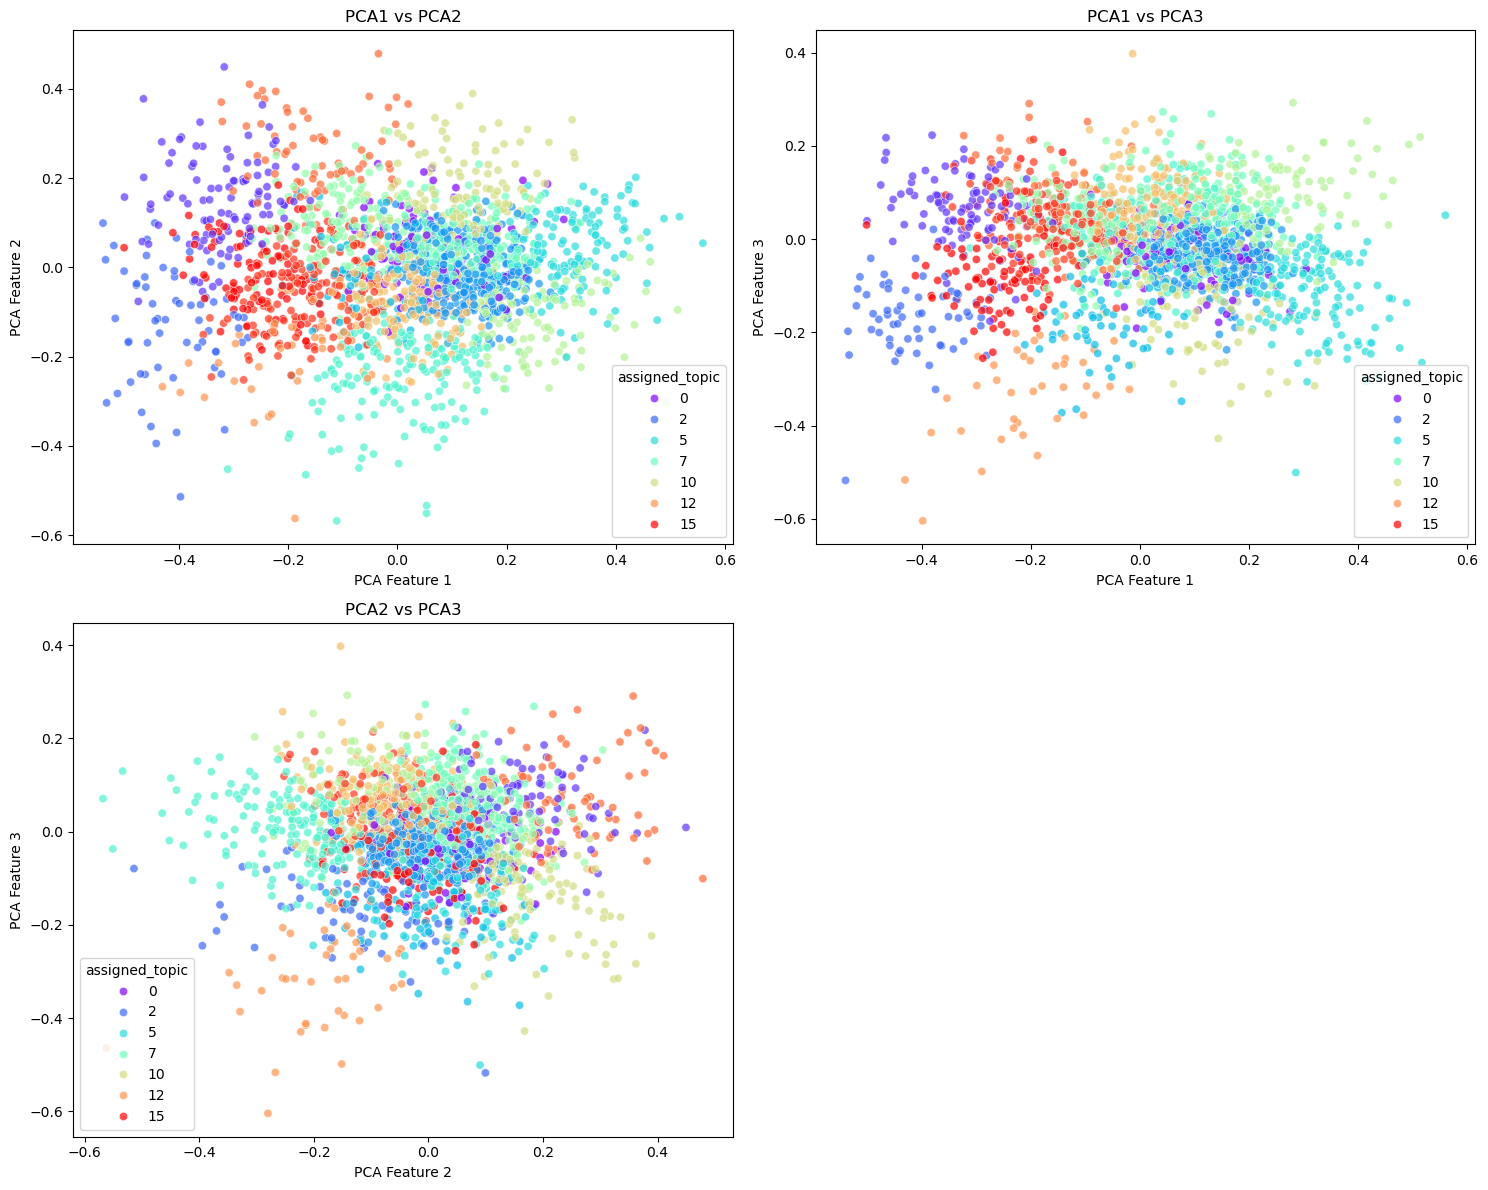

In [34]:
# Convert to Pandas DataFrame
kmeans_df = kmeans_res.toPandas()
# Extract PCA features into separate columns
kmeans_df[['PCA1', 'PCA2', 'PCA3']] = pd.DataFrame(pandas_df['PCA_Features'].tolist(), index=pandas_df.index)[[0, 1, 2]]

pca_plot(kmeans_df, 'assigned_topic', 'rainbow')

# Clusters description

In [27]:
# Afficher les centres des groupes
centres = modele.clusterCenters()
print("Centres : ")
for centre in modele.clusterCenters():
    print(centre)

NameError: name 'modele' is not defined

# Save results classification

In [35]:
import os
from pyspark.sql.functions import expr, col, array_max
import datetime

# Create the folder if it doesn't exist
output_folder = os.path.join(path, '2-AbstractsCollection/Classification_results')
os.makedirs(output_folder, exist_ok=True)

# Save the list of articles (pmid + topic assigned)
date = datetime.datetime.now().strftime("%Y-%m-%d")
articles_output_path = os.path.join(output_folder, f'articles_dov2vec_kmeans16_{date}.csv')
kmeans_df.to_csv(articles_output_path, index=False)
